Problems

The task is to create a python script, real time getting data feed from any crypto options exchange eg. Deribit, Delta, Bit.com, etc. (choose 1 is ok), and to come up with a Quadratic Equation on the volatility curve of both call & put.

For example, here is an option chain snapshot from the crypto options exchange Deribit.

Contract month: 24 Jun 2022
Underlying: BTC
Input: Mark IV of different strikes of both call & put (including OTM, ATM, ITM)
Re-fitting frequency: 1 or 5 min (up to you)

Steps:
Read API documents on Deribit
Get the mark IV of different strikes of 24 Jun contract, for both call & put
Use those mark IV to generate a quadratic equation
Print the equation every 1 / 5 min

Outcome:
1. A python script (in .py format) that can print the above-mentioned equation in real time



In [57]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import datetime
from sklearn.metrics import r2_score

# Helper Function
def unix_to_date_str(unix_timestamp):
    return datetime.datetime.utcfromtimestamp(unix_timestamp/1000).strftime('%Y-%m-%d')

In [2]:
EXCHANGE_URL = "https://www.deribit.com/api/v2/public"
INSTRUMENTS_END_POINT = "/get_instruments"
ORDER_BOOK_END_POINT = "/get_order_book_by_instrument_id"
CURRENCY = "BTC"
KIND = "option"
CONTRACT_MONTH = "2022-06-24"

payloads = {"currency": CURRENCY, "kind": KIND }
res = requests.get(f"{EXCHANGE_URL}{INSTRUMENTS_END_POINT}",params=payloads)
option_list = res.json()['result']

In [3]:
#Step 1: Filter by Contract Month
relevant_options = [option for option in option_list if unix_to_date_str(option['expiration_timestamp']) == CONTRACT_MONTH]

In [5]:
#Step 2: For each option contract, take their intrument unique id and get the mark IV and store it
RATE_LIMIT = 5
results = []
count = 0

for option in relevant_options:
    if count % 5 == 0:
        time.sleep(1)
        print(f"count: {count}")
    payloads = {"instrument_id": option['instrument_id']}
    res = requests.get(f"{EXCHANGE_URL}{ORDER_BOOK_END_POINT}",params=payloads)
    
    strike_price = option['strike']
    option_type = option['option_type']
    mark_iv = res.json()['result']['mark_iv']
    
    results.append([option_type, strike_price, mark_iv])
    count += 1

count: 0
count: 5
count: 10
count: 15
count: 20
count: 25
count: 30
count: 35
count: 40
count: 45
count: 50
count: 55
count: 60
count: 65
count: 70


In [ ]:
# Step 3: Take those calls and puts and sorted by strike price and fit a quadratic curve on the mark IV

In [85]:
calls = [i for i in results if i[0] == 'call']
calls = sorted(calls,key=lambda l:l[1], reverse=False)
puts = [i for i in results if i[0] == 'put']
puts = sorted(puts,key=lambda l:l[1], reverse=False)

In [86]:
calls_x = [call[1] for call in calls]
calls_y = [call[2] for call in calls]
puts_x = [put[1] for put in puts]
puts_y = [put[2] for put in puts]


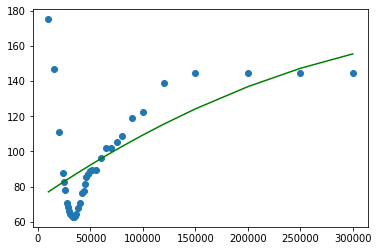

In [87]:
model = np.poly1d(np.polyfit(calls_x,calls_y, 2))
plt.plot(calls_x, model(calls_x),color='g')
plt.scatter(calls_x, calls_y)

In [88]:
print(f"Equation: {model}")
print(f"R-Square: {r2_score(calls_y, model(calls_x))}")

Equation:             2
-4.434e-10 x + 0.0004082 x + 72.95
R-Square: 0.3548286298829062


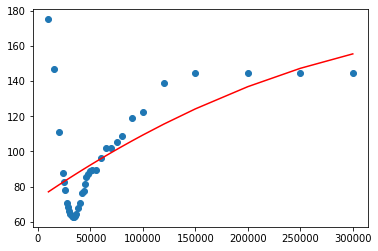

In [89]:
model = np.poly1d(np.polyfit(puts_x,puts_y, 2))
plt.plot(puts_x, model(puts_x),color='r')
plt.scatter(puts_x, puts_y)

In [90]:
print(f"Equation: {model}")
print(f"R-Square: {r2_score(puts_y, model(puts_x))}")

Equation:             2
-4.431e-10 x + 0.0004081 x + 72.96
R-Square: 0.3547887117392535


In [107]:
# Step 3.1: Excluding data point from very high strike price for the sake of better r-square

Equation:            2
1.229e-07 x - 0.009554 x + 250.4
R-Square: 0.8752664401795751


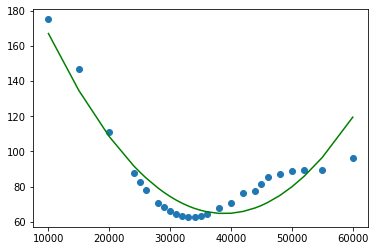

In [128]:
calls = [i for i in results if i[0] == 'call']
calls = sorted(calls,key=lambda l:l[1], reverse=False)

calls_x = [call[1] for call in calls if call[1] <= 60000]
calls_y = [call[2] for call in calls if call[1] <= 60000]

model = np.poly1d(np.polyfit(calls_x,calls_y, 2))
plt.plot(calls_x, model(calls_x),color='g')
plt.scatter(calls_x, calls_y)

print(f"Equation: {model}")
print(f"R-Square: {r2_score(calls_y, model(calls_x))}")


Equation:            2
1.229e-07 x - 0.009554 x + 250.4
R-Square: 0.8752847518884187


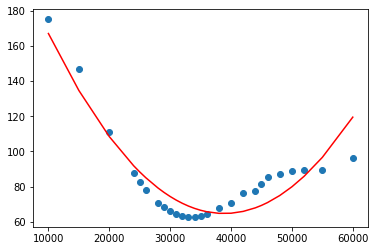

In [130]:
puts = [i for i in results if i[0] == 'put']
puts = sorted(puts,key=lambda l:l[1], reverse=False)

puts_x = [put[1] for put in puts if put[1] <= 60000]
puts_y = [put[2] for put in puts if put[1] <= 60000]

model = np.poly1d(np.polyfit(puts_x,puts_y, 2))
plt.plot(puts_x, model(puts_x),color='r')
plt.scatter(puts_x, puts_y)

print(f"Equation: {model}")
print(f"R-Square: {r2_score(puts_y, model(puts_x))}")

In [131]:
!pip install schedule